In [1]:
# importing the dependencies
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model
import keras
from keras.models import Model
from keras.models import Sequential
from keras.layers import MaxPool2D , LayerNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Activation, Input, Conv2D, Add, Flatten, AveragePooling2D, Dense, Dropout, BatchNormalization
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
import h5py

In [2]:
for dirname, _, filenames in os.walk('..\Datasets\Digit Recognizer'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

..\Datasets\Digit Recognizer\sample_submission.csv
..\Datasets\Digit Recognizer\test.csv
..\Datasets\Digit Recognizer\test.csv.zip
..\Datasets\Digit Recognizer\train.csv
..\Datasets\Digit Recognizer\train.csv.zip


In [3]:
# loading the dataset
train_df = pd.read_csv("../Datasets/Digit Recognizer/train.csv")
test_df = pd.read_csv("../Datasets/Digit Recognizer/test.csv")
train = pd.read_csv("../Datasets/Digit Recognizer/train.csv") 
test = pd.read_csv("../Datasets/Digit Recognizer/test.csv")

In [4]:
y = train_df['label']
del train_df['label']

In [5]:
y = y.values

In [6]:
from sklearn.preprocessing import LabelBinarizer
label_binarizer = LabelBinarizer()
y_train_bin = label_binarizer.fit_transform(y)

In [7]:
X_train = train_df.values
X_test = test_df.values

In [8]:
# Normalize the data
X_train = X_train / 255
X_test = X_test / 255

In [9]:
X_train_all = X_train.reshape(X_train.shape[0],28, 28,1).astype('float32')
X_test_all = X_test.reshape(X_test.shape[0],28, 28,1).astype('float32')

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train_all, y, test_size=0.20, random_state=42, shuffle=True)

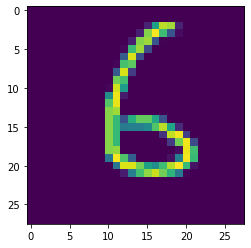

6

In [11]:
index = 123
plt.imshow(X_train[index])
plt.show()
y_train[index]

In [12]:
def blocks(x, strides, filters):
    y = x
    
    x = Conv2D(filters, kernel_size = 3, padding = "same", strides = strides)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    x = Conv2D(filters, kernel_size = 3, padding = "same", strides = (1, 1))(x)
    x = BatchNormalization()(x)
    
    
    if strides[0] > 1:
        y = Conv2D(filters, kernel_size = 3, padding = "same", strides = strides)(y)
        y = BatchNormalization()(y)
        
    x = Add()([x, y])
    return x

In [13]:
def residual_net(input_shape, num_classes, filters, blks):
    inputs = Input(input_shape)
    x = Conv2D(filters, kernel_size = 7, padding = "same", strides = (1, 1))(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    # Adding residual blocks
    for block in blks:
        x = blocks(x, strides = (2, 2), filters = filters)
        for i in range(block - 1):
            x = blocks(x, strides = (1, 1), filters = filters)
        filters *= 2
        
    x = AveragePooling2D(4)(x)
    x = Flatten()(x)
    x = Dropout(0.3)(x)
    x = Dense(int(filters/4), activation='relu')(x)
    outputs = Dense(10, activation='softmax')(x)
    
    # Instantiate model
    model = Model(inputs=inputs, outputs=outputs)
    return model  

In [14]:
model = residual_net(
    input_shape=X_train[0].shape, 
    num_classes=10, 
    filters=64, 
    blks=[2,2,2]
)
# resnet_architecture = plot_model(model, show_shapes=True, show_layer_names=False)
# resnet_architecture.width = 600
# resnet_architecture

In [15]:
def train(epochs, batch_size, i):
    model = residual_net(
    input_shape=X_train[0].shape, 
    num_classes=10, 
    filters=64, 
    blks=[3,3,3])
    
    model.compile(loss = "sparse_categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])
    
    checkpoint = ModelCheckpoint(
    filepath=f'resnet-{i}.hdf5',
    monitor='loss',
    save_best_only=True
    )
    def scheduler(epoch):
        return 0.001 * 0.8**epoch
    schedule = LearningRateScheduler(scheduler)
    callbacks = [checkpoint, schedule]
    
    train_datagen = ImageDataGenerator(  
        rotation_range=10,  
        zoom_range=0.1, 
        width_shift_range=0.1, 
        height_shift_range=0.1)
    
    train_datagen.fit(X_train)

    # Fit model
    history = model.fit_generator(
        train_datagen.flow(X_train, y_train, batch_size=batch_size),
        epochs=epochs, 
        verbose=2, 
        callbacks=callbacks)
    
    return history, model

In [16]:
models = []
all_history = []
for i in range(4):
    print("#"*20)
    print(f"Model number {i + 1}")
    print("#"*20)
    
    history, model = train(
        epochs=12,
        batch_size=128, i = i+1)
    
    models.append(model)
    all_history.append(history)

####################
Model number 1
####################


C:\Users\tahmi\AppData\Local\Temp/ipykernel_2520/124342405.py:29: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/12
263/263 - 864s - loss: 0.2607 - accuracy: 0.9163 - lr: 0.0010 - 864s/epoch - 3s/step
Epoch 2/12
263/263 - 915s - loss: 0.0886 - accuracy: 0.9742 - lr: 8.0000e-04 - 915s/epoch - 3s/step
Epoch 3/12
263/263 - 796s - loss: 0.0608 - accuracy: 0.9807 - lr: 6.4000e-04 - 796s/epoch - 3s/step
Epoch 4/12
263/263 - 783s - loss: 0.0441 - accuracy: 0.9867 - lr: 5.1200e-04 - 783s/epoch - 3s/step
Epoch 5/12
263/263 - 754s - loss: 0.0388 - accuracy: 0.9879 - lr: 4.0960e-04 - 754s/epoch - 3s/step
Epoch 6/12
263/263 - 777s - loss: 0.0313 - accuracy: 0.9904 - lr: 3.2768e-04 - 777s/epoch - 3s/step
Epoch 7/12
263/263 - 734s - loss: 0.0281 - accuracy: 0.9913 - lr: 2.6214e-04 - 734s/epoch - 3s/step
Epoch 8/12
263/263 - 738s - loss: 0.0258 - accuracy: 0.9917 - lr: 2.0972e-04 - 738s/epoch - 3s/step
Epoch 9/12
263/263 - 736s - loss: 0.0223 - accuracy: 0.9933 - lr: 1.6777e-04 - 736s/epoch - 3s/step
Epoch 10/12
263/263 - 728s - loss: 0.0185 - accuracy: 0.9941 - lr: 1.3422e-04 - 728s/epoch - 3s/step
Epo

KeyboardInterrupt: 

In [18]:
models

In [17]:
def create_submission(predictions,keys,path):
    result = pd.DataFrame(
        predictions,
        columns=['Label'],
        index=keys
        )
    result.index.name='ImageId'
    result.to_csv(path, index=True)

In [19]:
predictions_prob_0=models[0].predict(X_test_all)
predictions_prob_1=models[1].predict(X_test_all) 

875/875 [==============================] - 127s 145ms/step


In [20]:
labels_0=[np.argmax(pred) for pred in predictions_prob_0]
labels_1=[np.argmax(pred) for pred in predictions_prob_0]

In [21]:
keys=[i for i in range(1,28001) ]

In [22]:
create_submission(predictions=labels_0,keys=keys,path='submission_resnet_0.csv')
create_submission(predictions=labels_1,keys=keys,path='submission_resnet_1.csv')

Prediction Score on Kaggle: 0.99282